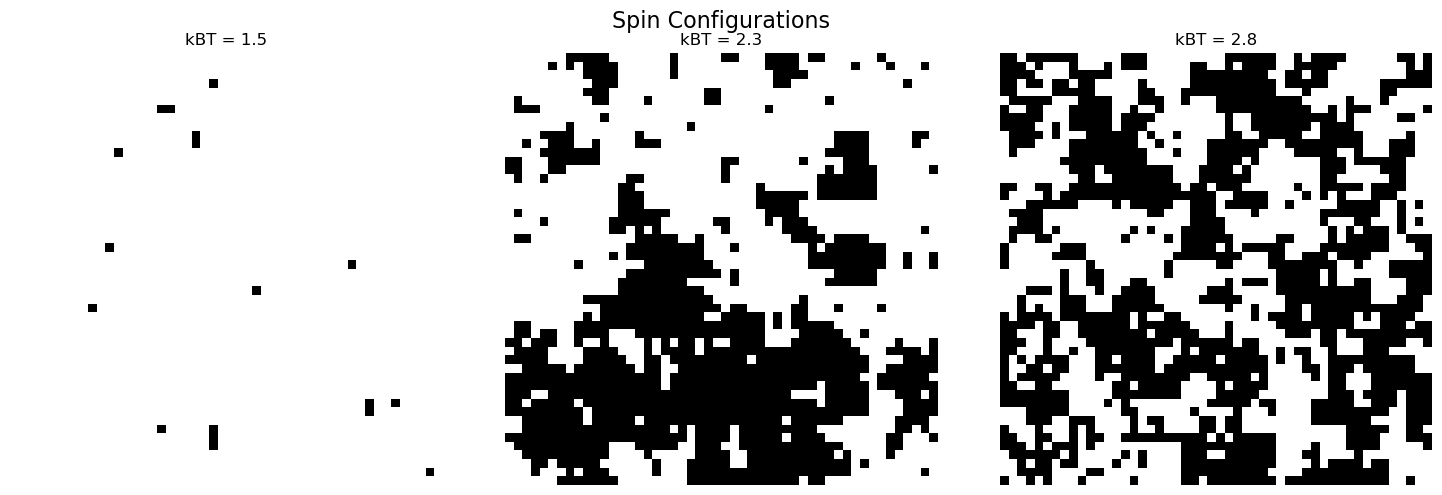

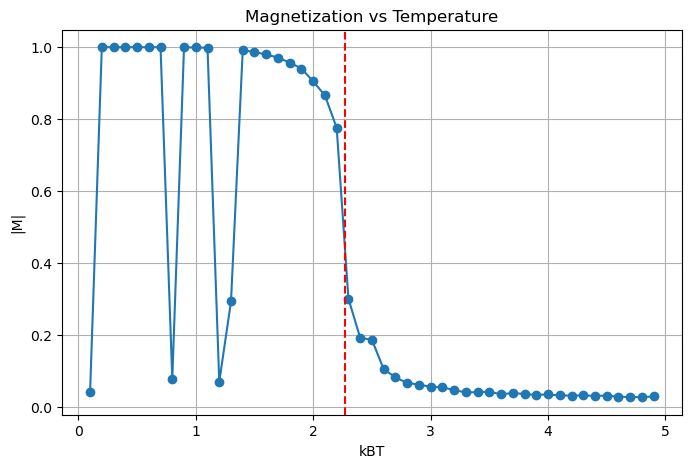

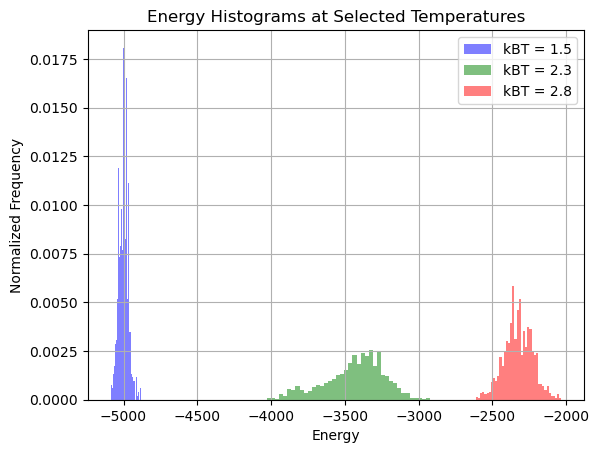

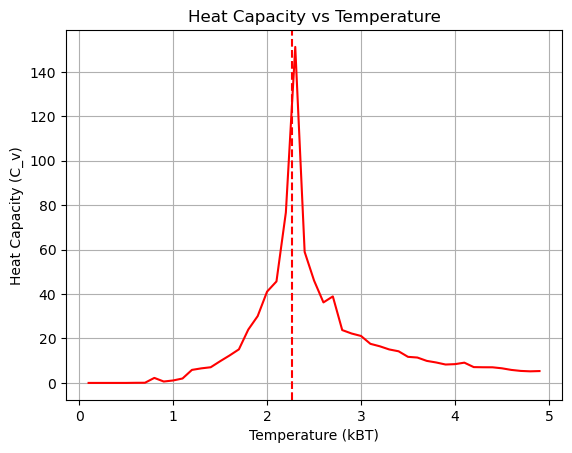

In [19]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from numba import njit

N=50
J=1
H=0

#periodic boundary condition
@njit
def periodic(grid):
  grid[0]=grid[N]
  grid[:,0]=grid[:,N]
  grid[N+1]=grid[1]
  grid[:,N+1]=grid[:,1]


#neighbours
@njit
def neighbours(i,j,grid):
  top=grid[i-1,j]
  bottom=grid[i+1,j]
  left=grid[i,j-1]
  right=grid[i,j+1]
  return np.array([top,bottom,left,right])

@njit
def EM(grid):
  nsums= np.zeros((N,N))

  for i in range(1,N+1):
    for j in range(1,N+1):
      nsums[i-1,j-1]=grid[i,j]*np.sum(neighbours(i,j,grid))
  E=-J*np.sum(nsums)
  M=np.sum(grid[1:N+1,1:N+1])/N**2
  return E,M

#randomly fliping probability
@njit
def flip(E,M,KbT,grid,H):
  i=np.random.randint(1,N+1)
  j=np.random.randint(1,N+1)

  spin=grid[i,j]

  nesum=np.sum(neighbours(i,j,grid))
  deltaE=2*J*spin*nesum + 2*H*spin


  if deltaE<=0 or np.random.rand()<np.exp(-deltaE/KbT):
    grid[i,j]=-spin
    periodic(grid)
    E=E+deltaE
    M=M+ (-2*spin/N**2)
    #E,M=EM(grid)
    #print(deltaE)
  return E,M


@njit
def sweep(E,M,KbT,grid,H):
  for _ in range(N*N):
    E,M=flip(E,M,KbT,grid,H)

  return E,M


avgmag=[]
avgE=[]
Cv=[]
energy_snapshots = {}
spin_snapshots = {}

kbtarr=np.arange(0.1,5,0.1)


for kbt in kbtarr:
    mag = []
    Earr = []
    gridt = np.random.choice([-1, 1], size=(N+2, N+2))
    periodic(gridt)
    E, M = EM(gridt)

    #Thermalization Steps
    for _ in range(10000):                       
        E, M = sweep(E, M, kbt, gridt,H)


    #Measurement Steps    
    for _ in range(1000):
        E, M = sweep(E, M, kbt, gridt,H)
        mag.append(np.abs(M))
        Earr.append(E)

    avgmag.append(np.mean(mag))
    avgE.append(np.mean(Earr))
    Cv.append((np.var(Earr)/N)/kbt**2)

    if np.isclose(kbt, 1.5, atol=0.01) or np.isclose(kbt, 2.269, atol=0.04) or np.isclose(kbt, 2.8, atol=0.01):
        energy_snapshots[round(kbt, 3)] = Earr.copy()
        spin_snapshots[round(kbt, 3)] = gridt[1:N+1, 1:N+1].copy()  # Save the core grid


    
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
temps_to_plot = [1.5, 2.3, 2.8]
titles = [f"kBT = {T}" for T in temps_to_plot]

for i, T in enumerate(temps_to_plot):
    grid_img = spin_snapshots[round(T, 3)]
    axs[i].imshow(grid_img, cmap='gray', interpolation='nearest')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

fig.suptitle("Spin Configurations", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
colors = ['blue', 'green', 'red']


#Magnetization 
plt.plot(kbtarr, avgmag, marker='o')
plt.title("Magnetization vs Temperature")
plt.xlabel("kBT")
plt.ylabel("|M|")
plt.axvline(x=2.269, color='red', linestyle='--', label='Theoretical $T_c$')
plt.grid(True)
plt.show()

#Energy histograms
for i, (temp, energies) in enumerate(energy_snapshots.items()):
    plt.hist(energies, bins=40, alpha=0.5, label=f"kBT = {temp}", color=colors[i], density=True)
plt.title("Energy Histograms at Selected Temperatures")
plt.xlabel("Energy")
plt.ylabel("Normalized Frequency")
plt.legend()
plt.grid(True)
plt.show()


#Specific Heat 
plt.plot(kbtarr, Cv , color='red')
plt.xlabel("Temperature (kBT)")
plt.ylabel("Heat Capacity (C_v)")
plt.title("Heat Capacity vs Temperature")
plt.axvline(x=2.269, color='red', linestyle='--', label='Theoretical $T_c$')
plt.grid(True)
plt.show()

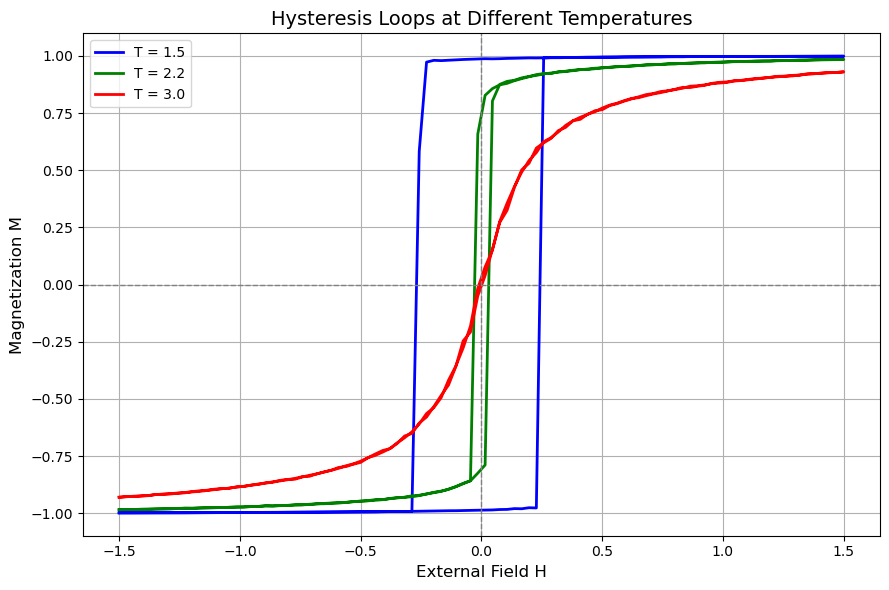

In [ ]:
temps = [1.5, 2.2, 3.0]  # Choose low, near-critical, and high T
H_max = 1.5
steps = 100
H_vals_up = np.linspace(-H_max, H_max, steps)
H_vals_down = np.linspace(H_max, -H_max, steps)
H_vals = np.concatenate((H_vals_up, H_vals_down))

plt.figure(figsize=(9, 6))
colors = ['blue', 'green', 'red']

for idx, T in enumerate(temps):
    grid = np.ones((N+2, N+2))  # Start from ordered grid for each T
    periodic(grid)
    E, M = EM(grid)
    mags_hyst = []

    for H in H_vals:
        # Relax system
        for _ in range(300):
            E, M = sweep(E, M, T, grid, H)

        # Measure
        mag_vals = []
        for _ in range(300):
            E, M = sweep(E, M, T, grid, H)
            mag_vals.append(M)

        mags_hyst.append(np.mean(mag_vals))

    plt.plot(H_vals, mags_hyst, label=f"T = {T}", lw=2, color=colors[idx])

# Final plot formatting
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.title("Hysteresis Loops ", fontsize=14)
plt.xlabel("External Field H", fontsize=12)
plt.ylabel("Magnetization M", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


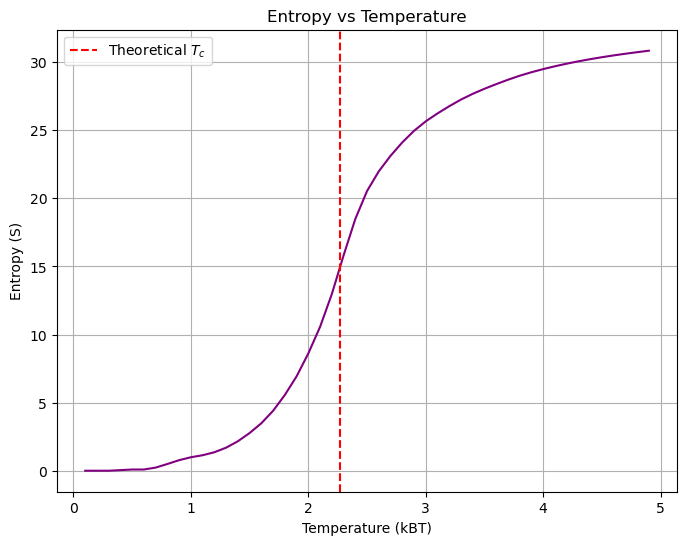

In [17]:
# Convert lists to numpy arrays
T_vals = np.array(kbtarr)
Cv_vals = np.array(Cv)

# Integrate Cv/T to get S(T)
integrand = Cv_vals / T_vals
entropy = np.array([np.trapz(integrand[:i+1], T_vals[:i+1]) for i in range(len(T_vals))])

plt.figure(figsize=(8,6))
plt.plot(T_vals, entropy, color='purple')
plt.title("Entropy vs Temperature")
plt.xlabel("Temperature (kBT)")
plt.ylabel("Entropy (S)")
plt.grid(True)
plt.axvline(x=2.269, color='red', linestyle='--', label='Theoretical $T_c$')
plt.legend()
plt.show()


H=0.2

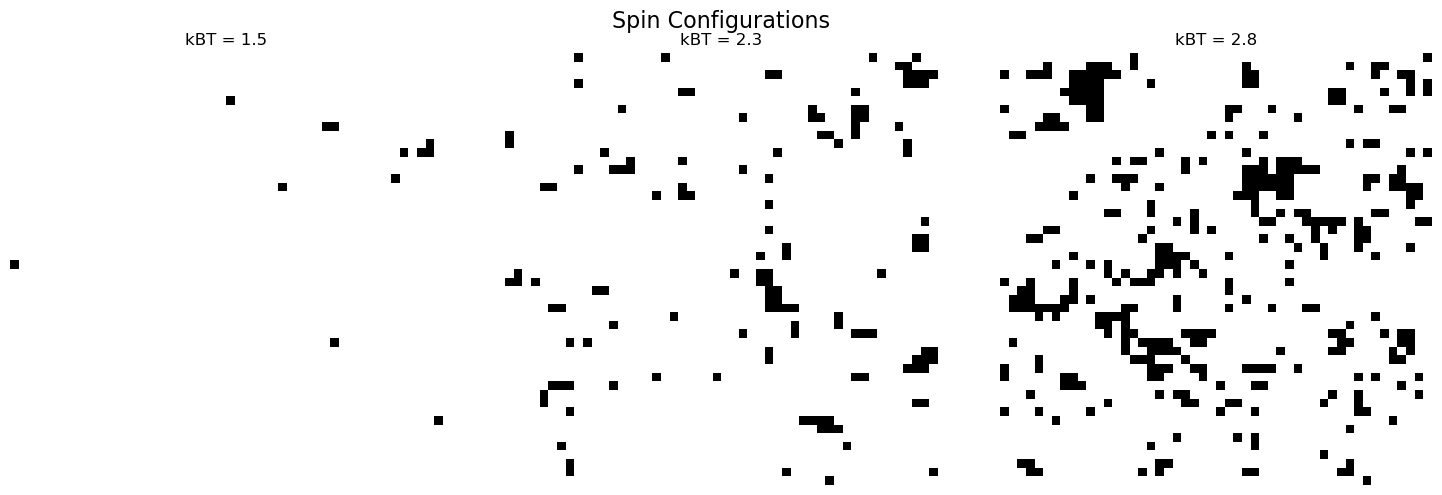

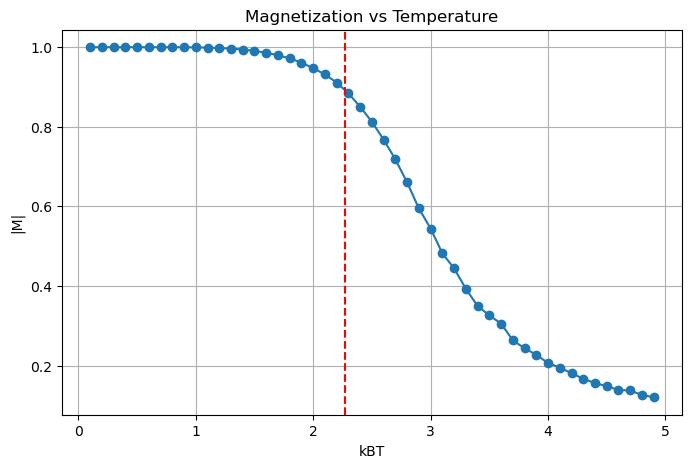

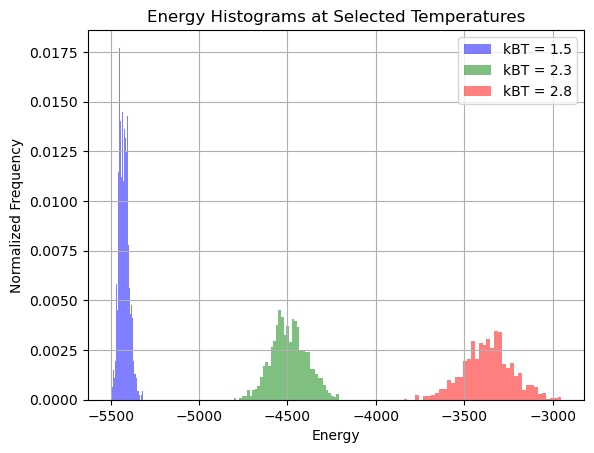

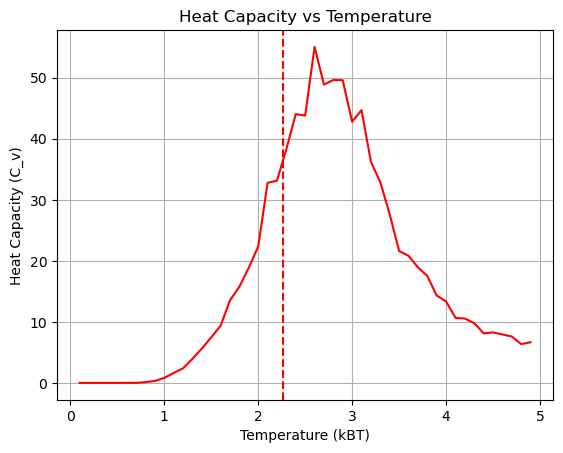

In [18]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from numba import njit

N=50
J=1
H=0.2

#periodic boundary condition
@njit
def periodic(grid):
  grid[0]=grid[N]
  grid[:,0]=grid[:,N]
  grid[N+1]=grid[1]
  grid[:,N+1]=grid[:,1]


#neighbours
@njit
def neighbours(i,j,grid):
  top=grid[i-1,j]
  bottom=grid[i+1,j]
  left=grid[i,j-1]
  right=grid[i,j+1]
  return np.array([top,bottom,left,right])

@njit
def EM(grid):
  nsums= np.zeros((N,N))

  for i in range(1,N+1):
    for j in range(1,N+1):
      nsums[i-1,j-1]=grid[i,j]*np.sum(neighbours(i,j,grid))
  E=-J*np.sum(nsums)
  M=np.sum(grid[1:N+1,1:N+1])/N**2
  return E,M

#randomly fliping probability
@njit
def flip(E,M,KbT,grid,H):
  i=np.random.randint(1,N+1)
  j=np.random.randint(1,N+1)

  spin=grid[i,j]

  nesum=np.sum(neighbours(i,j,grid))
  deltaE=2*J*spin*nesum + 2*H*spin


  if deltaE<=0 or np.random.rand()<np.exp(-deltaE/KbT):
    grid[i,j]=-spin
    periodic(grid)
    E=E+deltaE
    M=M+ (-2*spin/N**2)
    #E,M=EM(grid)
    #print(deltaE)
  return E,M


@njit
def sweep(E,M,KbT,grid,H):
  for _ in range(N*N):
    E,M=flip(E,M,KbT,grid,H)

  return E,M


avgmag=[]
avgE=[]
Cv=[]
energy_snapshots = {}
spin_snapshots = {}

kbtarr=np.arange(0.1,5,0.1)


for kbt in kbtarr:
    mag = []
    Earr = []
    gridt = np.random.choice([-1, 1], size=(N+2, N+2))
    periodic(gridt)
    E, M = EM(gridt)

    #Thermalization Steps
    for _ in range(10000):                       
        E, M = sweep(E, M, kbt, gridt,H)


    #Measurement Steps    
    for _ in range(1000):
        E, M = sweep(E, M, kbt, gridt,H)
        mag.append(np.abs(M))
        Earr.append(E)

    avgmag.append(np.mean(mag))
    avgE.append(np.mean(Earr))
    Cv.append((np.var(Earr)/N)/kbt**2)

    if np.isclose(kbt, 1.5, atol=0.01) or np.isclose(kbt, 2.269, atol=0.04) or np.isclose(kbt, 2.8, atol=0.01):
        energy_snapshots[round(kbt, 3)] = Earr.copy()
        spin_snapshots[round(kbt, 3)] = gridt[1:N+1, 1:N+1].copy()  # Save the core grid


    
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
temps_to_plot = [1.5, 2.3, 2.8]
titles = [f"kBT = {T}" for T in temps_to_plot]

for i, T in enumerate(temps_to_plot):
    grid_img = spin_snapshots[round(T, 3)]
    axs[i].imshow(grid_img, cmap='gray', interpolation='nearest')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

fig.suptitle("Spin Configurations", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
colors = ['blue', 'green', 'red']


#Magnetization 
plt.plot(kbtarr, avgmag, marker='o')
plt.title("Magnetization vs Temperature")
plt.xlabel("kBT")
plt.ylabel("|M|")
plt.axvline(x=2.269, color='red', linestyle='--', label='Theoretical $T_c$')
plt.grid(True)
plt.show()

#Energy histograms
for i, (temp, energies) in enumerate(energy_snapshots.items()):
    plt.hist(energies, bins=40, alpha=0.5, label=f"kBT = {temp}", color=colors[i], density=True)
plt.title("Energy Histograms at Selected Temperatures")
plt.xlabel("Energy")
plt.ylabel("Normalized Frequency")
plt.legend()
plt.grid(True)
plt.show()


#Specific Heat 
plt.plot(kbtarr, Cv , color='red')
plt.xlabel("Temperature (kBT)")
plt.ylabel("Heat Capacity (C_v)")
plt.title("Heat Capacity vs Temperature")
plt.axvline(x=2.269, color='red', linestyle='--', label='Theoretical $T_c$')
plt.grid(True)
plt.show()